# はじめに：必要なファイル  
jupyterと同階層にsub_modelフォルダを作成し、下記ファイルを配置のこと  
階層やファイル名を変更したい場合は、”モジュールをインポート”と”データとモデルファイルをインポート”においてpathを変更してください(計2箇所)

## データ
・master_2021_2022_30min_edit_ver2.csv  
## モデルファイル  
### Stage1 導電率モデル
・  OCWD_1st_Cond_modelfile
### Stage2 導電率モデル
・  OCWD_2nd_Cond_modelfile
### Stage3 導電率モデル
・  OCWD_3rd_Cond_modelfile
### Stage1 透過流量モデル
・  OCWD_1st_PermeateFlow_modelfile
### Stage2 透過流量モデル
・  OCWD_2nd_PermeateFlow_modelfile
### Stage3 透過流量モデル
・  OCWD_3rd_PermeateFlow_modelfile
### TOCモデル
・  OCWD_1st_Cond_modelfile
## 関数ファイル
・OCWD_water quality_submodel.py

# モジュールをインポート

In [10]:
#本番でも必要
from sub_model import OCWD_water_quality_submodel # ファイルパスを変更する場合fromの部分を変える必要あり
import math
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
#動作確認のみに使用
# import matplotlib.pyplot as plt
# from sklearn.linear_model import LinearRegression

# データとモデルファイルをインポート

In [2]:
# ファイルを直下に移動したくない場合は変更
base_folder_path = "sub_model/" 
csv_30min_path = base_folder_path + "master_2021_2022_30min_edit_ver2.csv"
#データをdf化
df30 = pd.read_csv(csv_30min_path, header=0, index_col=0, dtype=str)
df30_unit = df30["unit":]
df30 = df30[:df30.index.get_loc('unit')] 
df30.reset_index(inplace=True)
df30['Date / Time'] = pd.to_datetime(df30['Date / Time'])
df30.set_index("Date / Time",inplace=True)
df30 = df30.astype('float')
# model file をインポート
filename = 'OCWD_1st_Cond_modelfile'
First_Cond_model = pickle.load(open(base_folder_path + filename, 'rb'))
filename = 'OCWD_1st_PermeateFlow_modelfile'
First_Flow_model = pickle.load(open(base_folder_path + filename, 'rb'))
filename = 'OCWD_2nd_Cond_modelfile'
Second_Cond_model = pickle.load(open(base_folder_path + filename, 'rb'))
filename = 'OCWD_2nd_PermeateFlow_modelfile'
Second_Flow_model = pickle.load(open(base_folder_path + filename, 'rb'))
filename = 'OCWD_3rd_Cond_modelfile'
Third_Cond_model = pickle.load(open(base_folder_path + filename, 'rb'))
filename = 'OCWD_3rd_PermeateFlow_modelfile'
Third_Cond_model = pickle.load(open(base_folder_path + filename, 'rb'))
filename = 'OCWD_TOC_modelfile'
TOC_model = pickle.load(open(base_folder_path + filename, 'rb'))

# 使用するデータを抜き出し

In [3]:
# 計算タグの追加
df30, df30_unit = OCWD_water_quality_submodel.data_addition(df30, df30_unit)

# # 使用可能期間
# df30 = df30["2022-05-13 00:00:00":"2022-11-18 23:30:00"]

In [4]:
# 説明変数の選定
x_taglist, x_1st_Cond_varialbe, x_2nd_Cond_varialbe, x_3rd_Cond_varialbe, x_1st_PermeateFlow_varialbe, x_2nd_PermeateFlow_varialbe, x_3rd_PermeateFlow_varialbe, x_TOC_varialbe = OCWD_water_quality_submodel.set_x_variable()
# 目的変数の選定
y_taglist, y_1st_Cond_varialbe, y_2nd_Cond_varialbe, y_3rd_Cond_varialbe, y_1st_PermeateFlow_varialbe, y_2nd_PermeateFlow_varialbe, y_3rd_PermeateFlow_varialbe, y_TOC_varialbe = OCWD_water_quality_submodel.set_y_variable()

# 薬添のデータ加工(1日データを30分一定注入として加工)
x_drug_varialbe = OCWD_water_quality_submodel.set_drug_variable()
df30[x_drug_varialbe] = (df30[x_drug_varialbe]/48).interpolate('ffill')

In [5]:
# 全変数リスト
Taglist = x_taglist + y_taglist

# 評価期間 # 期間の適応
test_priod = ["2022-05-20 00:00:00","2022-05-26 23:30:00"]
use_data = df30[Taglist][test_priod[0]:test_priod[1]]

In [6]:
# 外れ値除去  median で補間 k=24 thr=3
use_data = use_data.apply(OCWD_water_quality_submodel.Hampel,k=24,thr=3)
# 標準化
use_data[x_taglist] = OCWD_water_quality_submodel.set_stds(use_data[x_taglist], x_taglist)

# 予測値の計算

In [7]:
# 各変数ごとの予測値
First_Cond_pre = First_Cond_model.predict(use_data[x_1st_Cond_varialbe])
Second_Cond_pre = Second_Cond_model.predict(use_data[x_2nd_Cond_varialbe])
Third_Cond_pre = Third_Cond_model.predict(use_data[x_3rd_Cond_varialbe])
First_Flow_pre = First_Flow_model.predict(use_data[x_1st_PermeateFlow_varialbe])
Second_Flow_pre = Second_Flow_model.predict(use_data[x_2nd_PermeateFlow_varialbe])
Third_Flow_pre = Third_Cond_model.predict(use_data[x_3rd_PermeateFlow_varialbe])
TOC_pre = TOC_model.predict(use_data[x_TOC_varialbe])

## 結果の描写

In [8]:
y_prediction = [First_Cond_pre, Second_Cond_pre, Third_Cond_pre, First_Flow_pre, Second_Flow_pre, Third_Flow_pre, TOC_pre]
ymin  = [5,15,20,1900,1000,200,0.02]
ymax = [20,45,120,2100,1200,450,0.12]

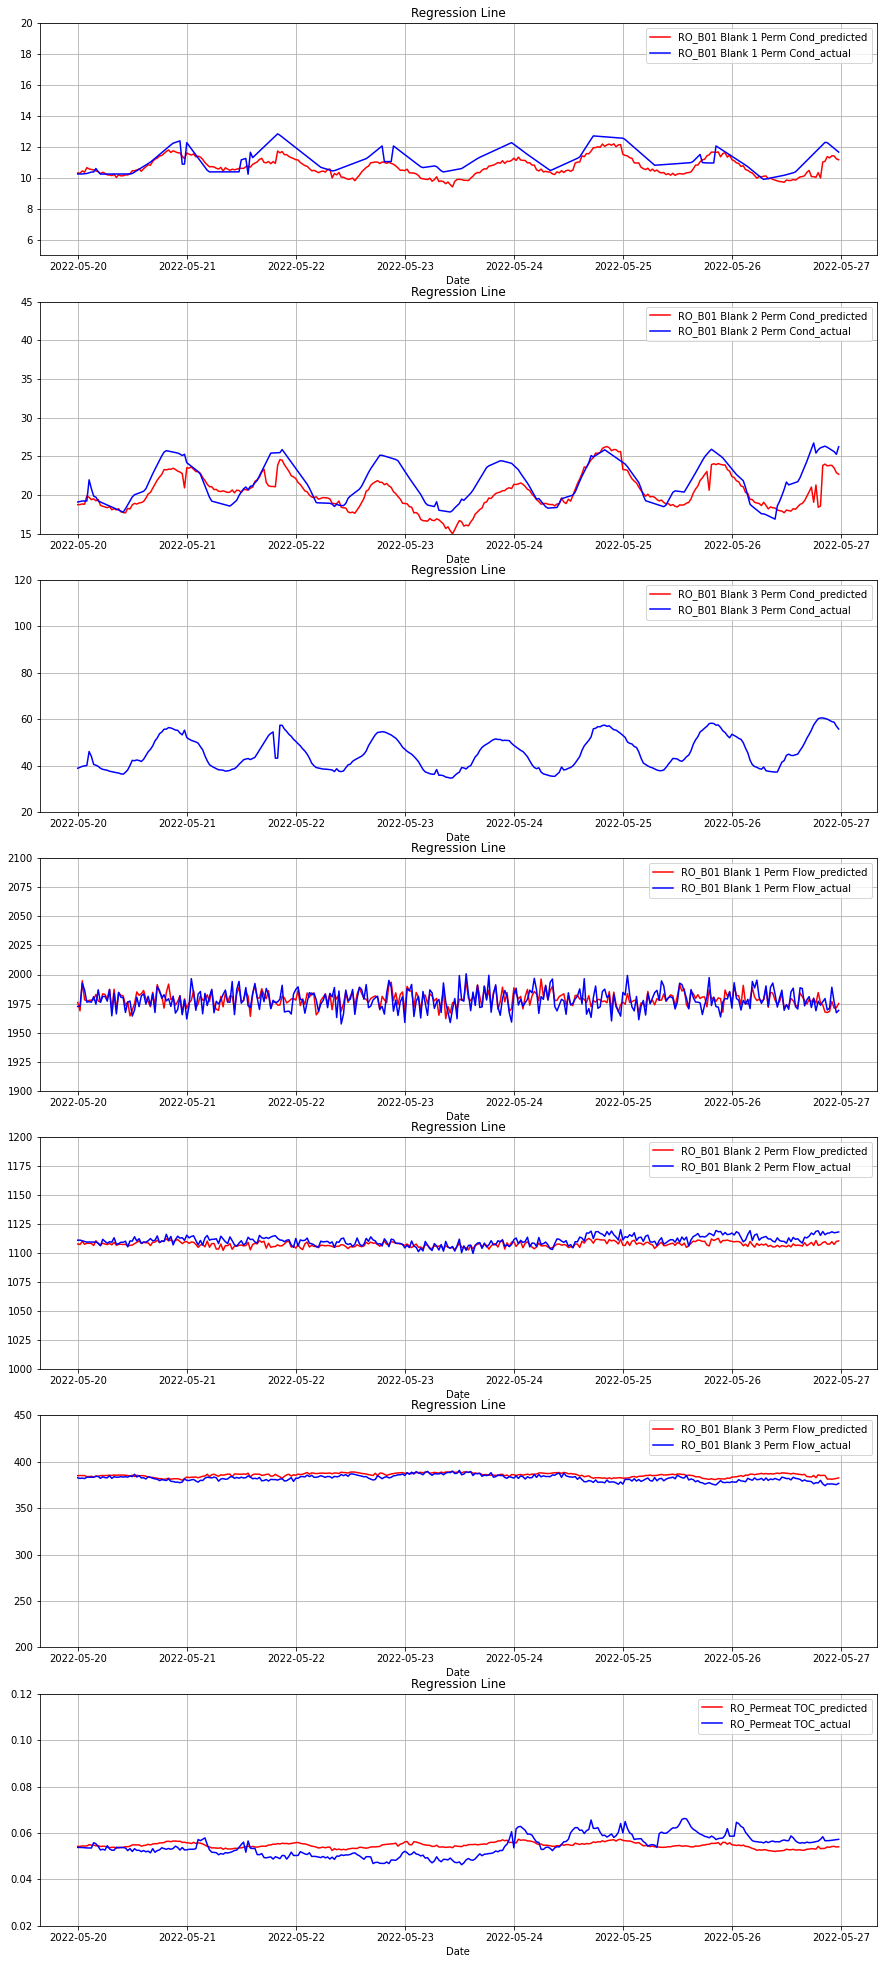

In [11]:
fig, ax = plt.subplots(len(y_prediction), figsize=(15, 35))
for i in range(len(y_prediction)):
    ax[i].plot(use_data.index, y_prediction[i], color = 'red', label = y_taglist[i] + "_predicted") # 回帰直線をプロット
    ax[i].plot(use_data.index, use_data[y_taglist[i]], color = 'blue', label = use_data[y_taglist[i]].name + "_actual")     # 実績値yをプロット
    ax[i].set_title('Regression Line')                # 図のタイトル
    ax[i].set_xlabel('Date')                          # x軸のラベル
    ax[i].set_ylim(ymin[i],ymax[i])
    ax[i].grid()                                  # グリッド線を表示
    ax[i].legend()
plt.show()  

# 制約について

導電率 [uS/cm] は0以上の値になるはずだと思います。  
実績値はそれぞれ下記になります。  
1段目：8～18  
2段目：14～40  
3段目：30～110  
基準値としては、全体で 95[uS/cm] 以下、各ユニットごとに 110[uS/cm] 以下となっています。

透過側流量 [gpm] は0以上の値になるはずだと思います。  
実績値はそれぞれ下記になります。  
1段目：1940～2100  
2段目：1080～1150  
3段目：250～400

TOC [uS/cm] は0以上の値になるはずだと思います。  
実績値は約0.04～0.1の間の値を取っています。  
基準値としては、0.1[mg/L] 以下となっています。